In [1]:
import sys
import warnings
#from torchtext import data

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.preprocessing import normalize
sns.set_context(context="talk")
%matplotlib inline


from keras import backend as K

def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

import keras
import os, re, sys
import pandas as pd
from keras.utils import to_categorical
import ast
from sklearn.utils import class_weight
from keras.preprocessing import sequence
from keras.models import load_model
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk import WordNetLemmatizer
import itertools
from collections import Counter
from os import listdir
from os.path import isfile, join
import  json
from sklearn.utils import class_weight


from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, Input
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import LSTM,GRU,Dense
from keras.utils import Sequence,to_categorical

stoplist = stopwords.words('english')
lemmatizer=WordNetLemmatizer()

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def cleaner(post):       
    s= re.sub(r"http\S+", " <url> ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " <hashtag> ", s) ########3
    s= re.sub(r'@\w+ ?', " <user> ", s)##############    
    s= s.lower()
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " <number> ",  s)
    s=re.sub(r'\b[0-9][0-9]\b', " <number> ",  s)
    s=re.sub(r'\b[0-9][0-9][0-9]\b', " <number> ",  s)
    s=re.sub(r'\b[0-9][0-9][0-9][0-9]\b', " <number> ",  s)
    s=emoji_pattern.sub(r'', s)
    s= list(s.split())
    s=[lemmatizer.lemmatize(token) for token in s]
        
    return s

def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Using TensorFlow backend.


In [2]:
df_train=pd.read_csv("../Train_data_compeition.csv")
df_val=pd.read_csv("../Validation_data_competition.csv")
df_test=pd.read_csv("../testset-competition.csv")

from collections import Counter
print ("conteo de tweets clase Harassment",Counter(df_train['harassment']))
print ("conteo de tweets clase IndirectH",Counter(df_train['IndirectH']))
print ("conteo de tweets clase PhysicalH",Counter(df_train['PhysicalH']))
print ("conteo de tweets clase SexualH",Counter(df_train['SexualH']))

conteo de tweets clase Harassment Counter({0: 3661, 1: 2713})
conteo de tweets clase IndirectH Counter({0: 6319, 1: 55})
conteo de tweets clase PhysicalH Counter({0: 6298, 1: 76})
conteo de tweets clase SexualH Counter({0: 3792, 1: 2582})


In [3]:
def invertir_valores(lista):
    new_lista=[]
    for reg in lista:
        temp=reg
        if reg[0]==0:
            temp[0]=1
        else:  #si el primero es 1, entonces se pone en 0 esa pos
            temp[0]=0
        new_lista.append(temp)
    return np.asarray(new_lista)           
            

In [4]:
etiquetas=df_train.values[:,2:]
etiquetas=invertir_valores(etiquetas)
etiquetas[:30]

array([[0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]], dtype=object)

In [5]:
y_train=etiquetas

In [6]:
y_train_num=[]
for reg in y_train:
    y_train_num.append(np.argmax(reg))
y_train_num=np.asarray(y_train_num)
y_train_num[:30]

array([3, 0, 0, 3, 3, 0, 3, 3, 0, 0, 0, 3, 0, 3, 3, 0, 0, 3, 0, 0, 3, 3,
       0, 3, 3, 0, 3, 0, 0, 3])

In [7]:
etiquetas_val=df_val.values[:,2:]
etiquetas_val=invertir_valores(etiquetas_val)
etiquetas_val[:30]
y_val=etiquetas_val
y_val_num=[]
for reg in y_val:
    y_val_num.append(np.argmax(reg))
y_val_num=np.asarray(y_val_num)
y_val_num[:30]

array([0, 0, 3, 0, 3, 0, 0, 3, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0,
       3, 3, 0, 3, 0, 3, 0, 3])

In [8]:
data_train=[]
for tw in df_train['tweet_content']:
    data_train.append(cleaner(tw))

    
embeddings_index = {}
#f = open(os.path.join("../../glove.twitter.27B/glove.twitter.27B.100d.txt"))#'glove.twitter.27B.100d.txt'))
f = open(os.path.join("../../Milenio/Twitter-stance-classification-by-TensorFlow/RNN_word2vec/data/glove.twitter.27B/glove.twitter.27B.100d.txt")) 
for line in f: 
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))
                                                                        
word_index=dict()
j=1
for frase in data_train:
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1
    
embedding_vector=100
embedding_matrix = np.zeros((len(word_index.keys())+1, embedding_vector))   #puede probar otra inicialización

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Se encontraron 1193514 terminos con sus vectores de embedding.


[ 0.43526359 28.97272727 20.96710526  0.61715724]


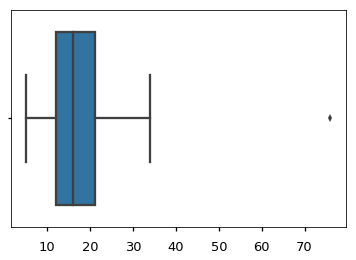

In [9]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_num), y_train_num)#{0: 3.,   1: 6.,   2: 5.,  3: 3.}
print (class_weights)
x_new_train = [[word_index[word] for word in text] for text in data_train]

sns.boxplot(list(map(len,x_new_train)))

In [10]:
max_input_lenght = max(list(map(len,x_new_train))) #modificar este valor en base a su experimentación
X_train = sequence.pad_sequences(x_new_train,maxlen=max_input_lenght,padding='post',value=0)
print (max_input_lenght) 
X_train.shape

data_val=[]
for tw in df_val['tweet_content']:
    data_val.append(cleaner(tw))
print (Counter(y_val_num))
    
    
Vec_train=[]
tweets_c_a=data_train
vocab_train=[]
vocab=list(embeddings_index.keys())
for post in tweets_c_a:
    posteo=[]
    for term in post:   #para todos los terminos de un tweet 
        vector=embeddings_index.get(term)
        if vector is None:       
            posteo.append(np.zeros(100))
        else:
            posteo.append(np.asarray(vector))
            vocab_train.append(term)
    Vec_train.append(np.asarray(posteo))
    
Vec_val_ig=[]
tweets_l_vali=data_val
vocab=list(embeddings_index.keys())
for post in tweets_l_vali:
    temp=[]
    for term in post:  
        if term in vocab_train:
            vector=embeddings_index.get(term)
            if vector is None:       
                temp.append(np.zeros(100))
            else:
                temp.append(np.asarray(vector))
    Vec_val_ig.append(temp)

all_val=[]
for text in data_val:
    temp=[]
    for word in text:
        try:
            temp.append(word_index[word])
        except:
            continue
    all_val.append(temp)
    
x_new_val=all_val
X_val_ig = sequence.pad_sequences(x_new_val,maxlen=max_input_lenght,padding='post',value=0)
print (np.asarray(X_val_ig).shape)

76
Counter({0: 1493, 3: 525, 1: 71, 2: 36})
(2125, 76)


In [41]:
embedding_vector=100
embedding_layer = Embedding(input_dim=len(word_index.keys())+1,output_dim=embedding_vector,weights=[embedding_matrix],
                     input_length=max_input_lenght,trainable=False)

sequence_input = Input(shape=(max_input_lenght,))
embedded_sequences = embedding_layer(sequence_input)
batch = BatchNormalization()(embedded_sequences)
cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
pool = MaxPooling1D(pool_size=3)(cov1)    
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
pool = MaxPooling1D(pool_size=3)(cov1)
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
flat = Flatten()(drop)
preds = Dense(64, activation='relu')(flat)
preds = BatchNormalization()(preds)
preds = Dense(4, activation='sigmoid')(preds)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [42]:
history = model.fit(X_train, y_train,batch_size=64,epochs=10,verbose=1,validation_data=(X_val_ig,y_val),class_weight=class_weights)

Train on 6374 samples, validate on 2125 samples
Epoch 1/10
6374/6374 [==============================] - 13s 2ms/step - loss: 1.1124 - acc: 0.4998 - val_loss: 0.5449 - val_acc: 0.8551
Epoch 2/10
6374/6374 [==============================] - 12s 2ms/step - loss: 0.7084 - acc: 0.7120 - val_loss: 0.5185 - val_acc: 0.8504
Epoch 3/10
6374/6374 [==============================] - 12s 2ms/step - loss: 0.5364 - acc: 0.7946 - val_loss: 0.4720 - val_acc: 0.8616
Epoch 4/10
6374/6374 [==============================] - 12s 2ms/step - loss: 0.4844 - acc: 0.8224 - val_loss: 0.4518 - val_acc: 0.8640
Epoch 5/10
6374/6374 [==============================] - 12s 2ms/step - loss: 0.4462 - acc: 0.8415 - val_loss: 0.4581 - val_acc: 0.8711
Epoch 6/10
6374/6374 [==============================] - 12s 2ms/step - loss: 0.4315 - acc: 0.8502 - val_loss: 0.4233 - val_acc: 0.8838
Epoch 7/10
6374/6374 [==============================] - 12s 2ms/step - loss: 0.4073 - acc: 0.8601 - val_loss: 0.4519 - val_acc: 0.8776
Epoch 8

[[8.1051779e-01 9.1678593e-03 5.1965737e-03 1.5243803e-02]
 [7.9607952e-01 3.2216266e-03 3.0696911e-03 9.7910399e-03]
 [2.6731791e-02 7.1624632e-04 4.6353601e-03 9.9997365e-01]
 [8.5105348e-01 6.6004591e-03 3.9528962e-03 7.4108955e-03]
 [3.2090488e-01 1.1997907e-02 1.9943450e-02 2.5391856e-01]]
[0 0 3 0 0]
Accuracy sobre validacion: 0.8785882352941177
F1-score None sobre validación: [0.92494411 0.         0.         0.82888229]
F1-score macro sobre validación: 0.4384566005179057
Precision None sobre validación: [0.88400488 0.         0.         0.86213992]
Recall None sobre validación: [0.96985934 0.         0.         0.79809524]


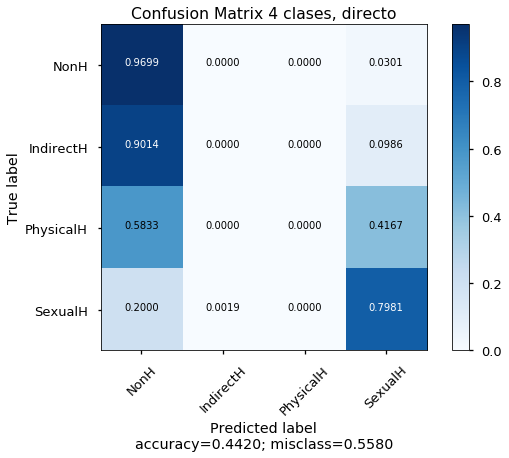

In [43]:
predict = model.predict(X_val_ig, batch_size=64)
print (predict[:5])
predict= predict.argmax(axis=-1)
print (predict[:5])
acc_val= accuracy_score(y_val_num, predict)
f1_val=f1_score(y_val_num, predict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_num, predict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_num, predict, average=None) 
pre=precision_score(y_val_num, predict, average=None) 
matriz_val=confusion_matrix(y_val_num, predict)
print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH",'IndirectH','PhysicalH','SexualH'],"Confusion Matrix 4 clases, directo")

In [11]:
class_weights

array([ 0.43526359, 28.97272727, 20.96710526,  0.61715724])

In [46]:
embedding_vector=100
embedding_layer = Embedding(input_dim=len(word_index.keys())+1,output_dim=embedding_vector,weights=[embedding_matrix],
                     input_length=max_input_lenght,trainable=False)

sequence_input = Input(shape=(max_input_lenght,))
embedded_sequences = embedding_layer(sequence_input)
batch = BatchNormalization()(embedded_sequences)
cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
pool = MaxPooling1D(pool_size=3)(cov1)    
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
pool = MaxPooling1D(pool_size=3)(cov1)
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
flat = Flatten()(drop)
preds = Dense(64, activation='relu')(flat)
preds = BatchNormalization()(preds)
preds = Dense(4, activation='softmax')(preds)
model = Model(sequence_input, preds)
model.compile(loss=focal_loss(2, class_weights),optimizer='adam',metrics=['acc'])

history = model.fit(X_train, y_train,batch_size=64,epochs=10,verbose=1,validation_data=(X_val_ig,y_val),class_weight=class_weights)

Train on 6374 samples, validate on 2125 samples
Epoch 1/10
6374/6374 [==============================] - 14s 2ms/step - loss: 1.4487 - acc: 0.2586 - val_loss: 1.3347 - val_acc: 0.1591
Epoch 2/10
6374/6374 [==============================] - 12s 2ms/step - loss: 1.0746 - acc: 0.2876 - val_loss: 1.4196 - val_acc: 0.4296
Epoch 3/10
6374/6374 [==============================] - 12s 2ms/step - loss: 1.1116 - acc: 0.3317 - val_loss: 1.3764 - val_acc: 0.5967
Epoch 4/10
6374/6374 [==============================] - 12s 2ms/step - loss: 0.9303 - acc: 0.3803 - val_loss: 1.2382 - val_acc: 0.7289
Epoch 5/10
6374/6374 [==============================] - 12s 2ms/step - loss: 0.7809 - acc: 0.4088 - val_loss: 1.1127 - val_acc: 0.4739
Epoch 6/10
6374/6374 [==============================] - 12s 2ms/step - loss: 0.7356 - acc: 0.4438 - val_loss: 1.1141 - val_acc: 0.4381
Epoch 7/10
6374/6374 [==============================] - 12s 2ms/step - loss: 0.6306 - acc: 0.4716 - val_loss: 1.0636 - val_acc: 0.4141
Epoch 8

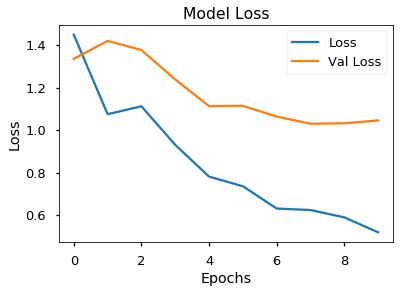

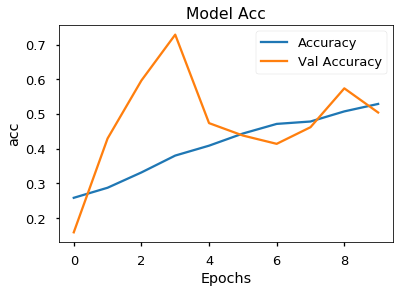

In [50]:
plt.plot(history.history['loss'],label="Loss")
plt.plot(history.history['val_loss'],label="Val Loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(history.history['acc'],label="Accuracy" )
plt.plot(history.history['val_acc'],label="Val Accuracy" )
plt.title("Model Acc") 
plt.ylabel('acc')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

[1 0 3 0 1]
Accuracy sobre validacion: 0.5044705882352941
F1-score None sobre validación: [0.62643172 0.11288805 0.04545455 0.68728522]
F1-score macro sobre validación: 0.36801488489125206
Precision None sobre validación: [0.91505792 0.06048387 0.125      0.86206897]
Recall None sobre validación: [0.47622237 0.84507042 0.02777778 0.57142857]


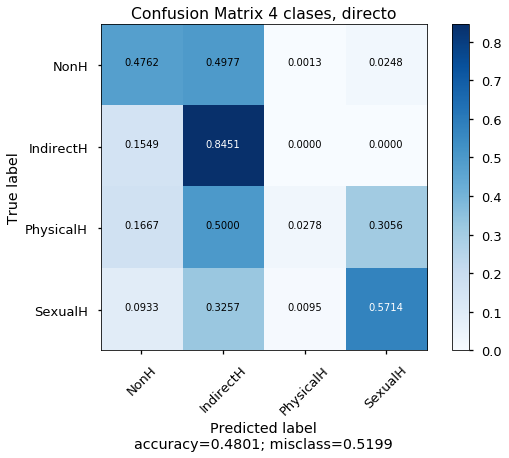

In [47]:
predict = model.predict(X_val_ig, batch_size=64)
predict= predict.argmax(axis=-1)
print (predict[:5])
acc_val= accuracy_score(y_val_num, predict)
f1_val=f1_score(y_val_num, predict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_num, predict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_num, predict, average=None) 
pre=precision_score(y_val_num, predict, average=None) 
matriz_val=confusion_matrix(y_val_num, predict)
print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH",'IndirectH','PhysicalH','SexualH'],"Confusion Matrix 4 clases, directo")

In [49]:
embedding_vector=100
embedding_layer = Embedding(input_dim=len(word_index.keys())+1,output_dim=embedding_vector,weights=[embedding_matrix],
                     input_length=max_input_lenght,trainable=False)

sequence_input = Input(shape=(max_input_lenght,))
embedded_sequences = embedding_layer(sequence_input)
batch = BatchNormalization()(embedded_sequences)
cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
pool = MaxPooling1D(pool_size=3)(cov1)    
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
pool = MaxPooling1D(pool_size=3)(cov1)
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
flat = Flatten()(drop)
preds = Dense(100, activation='relu')(flat)
preds = BatchNormalization()(preds)
preds = Dense(4, activation='softmax')(preds)
model = Model(sequence_input, preds)
model.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 76)                0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 76, 100)           1618900   
_________________________________________________________________
batch_normalization_25 (Batc (None, 76, 100)           400       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 76, 128)           64128     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 25, 128)           0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 25, 128)           512       
_________________________________________________________________
dropout_13 (Dropout)         (None, 25, 128)           0         
__________

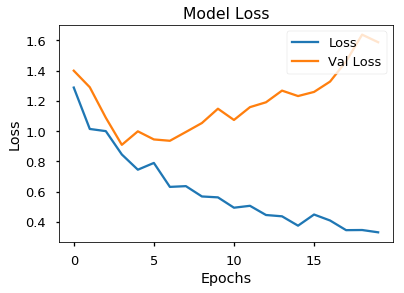

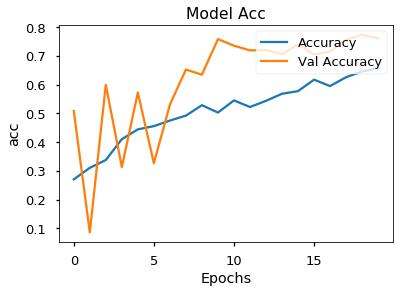

[0 0 2 0 0]
Accuracy sobre validacion: 0.7604705882352941
F1-score None sobre validación: [0.9092084  0.11940299 0.08029197 0.50870147]
F1-score macro sobre validación: 0.40440120727016104
Precision None sobre validación: [0.87827715 0.12698413 0.04621849 0.85585586]
Recall None sobre validación: [0.94239786 0.11267606 0.30555556 0.36190476]


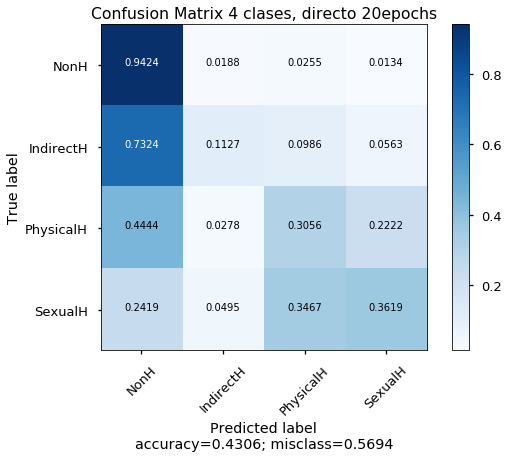

In [51]:
history = model.fit(X_train, y_train,batch_size=64,epochs=20,verbose=0,validation_data=(X_val_ig,y_val),class_weight=class_weights)
plt.plot(history.history['loss'],label="Loss")
plt.plot(history.history['val_loss'],label="Val Loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(history.history['acc'],label="Accuracy" )
plt.plot(history.history['val_acc'],label="Val Accuracy" )
plt.title("Model Acc") 
plt.ylabel('acc')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predict = model.predict(X_val_ig, batch_size=64)
predict= predict.argmax(axis=-1)
print (predict[:5])
acc_val= accuracy_score(y_val_num, predict)
f1_val=f1_score(y_val_num, predict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_num, predict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_num, predict, average=None) 
pre=precision_score(y_val_num, predict, average=None) 
matriz_val=confusion_matrix(y_val_num, predict)
print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH",'IndirectH','PhysicalH','SexualH'],"Confusion Matrix 4 clases, directo 20epochs")

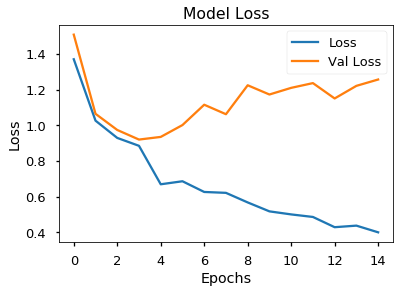

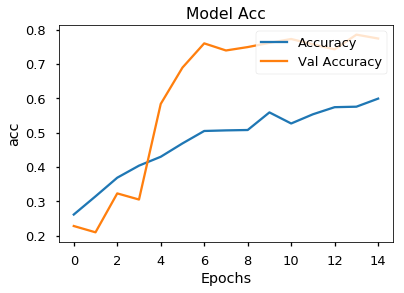

[0 0 3 0 2]
Accuracy sobre validacion: 0.7741176470588236
F1-score None sobre validación: [0.90700034 0.17894737 0.08       0.64947245]
F1-score macro sobre validación: 0.45385503919437276
Precision None sobre validación: [0.91598361 0.14285714 0.04672897 0.8445122 ]
Recall None sobre validación: [0.89819156 0.23943662 0.27777778 0.52761905]


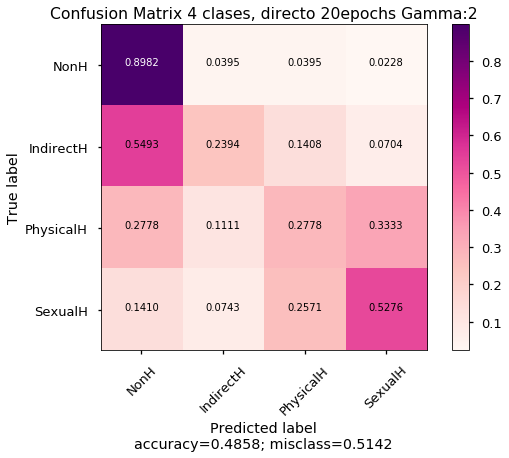

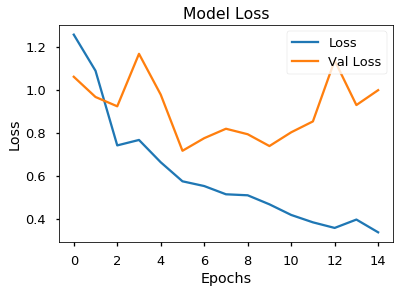

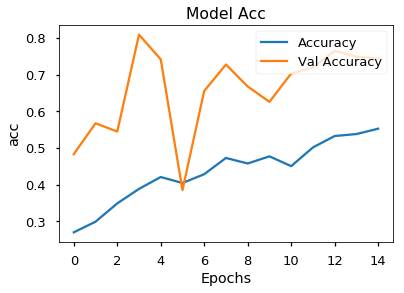

[0 0 3 0 2]
Accuracy sobre validacion: 0.744
F1-score None sobre validación: [0.90090674 0.10526316 0.07715134 0.48101266]
F1-score macro sobre validación: 0.39108347179636327
Precision None sobre validación: [0.87210031 0.13953488 0.04318937 0.91935484]
Recall None sobre validación: [0.93168118 0.08450704 0.36111111 0.32571429]


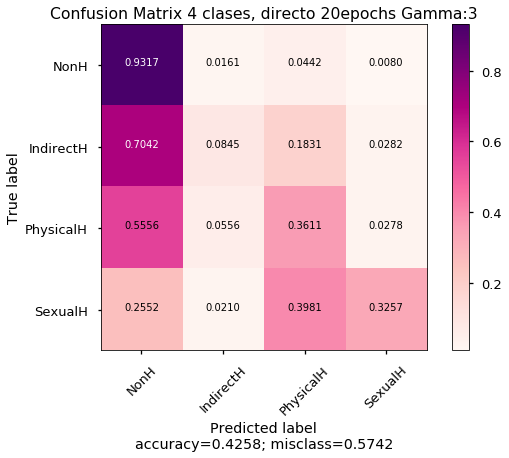

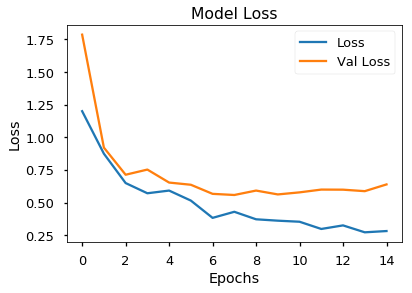

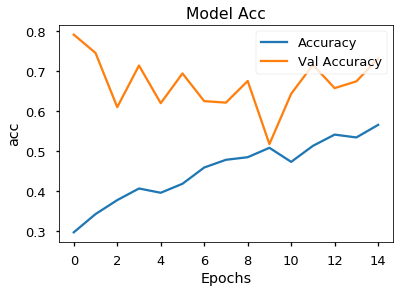

[0 0 2 0 1]
Accuracy sobre validacion: 0.7312941176470589
F1-score None sobre validación: [0.89350649 0.14124294 0.03007519 0.44216691]
F1-score macro sobre validación: 0.37674788250441654
Precision None sobre validación: [0.86704474 0.08833922 0.02061856 0.9556962 ]
Recall None sobre validación: [0.92163429 0.35211268 0.05555556 0.28761905]


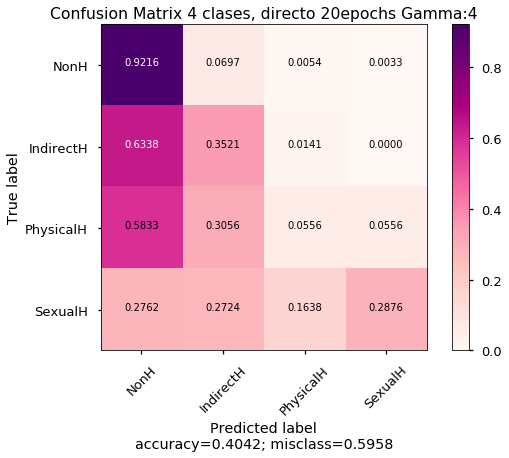

In [52]:
gammas=[2,3,4]
for gamma in gammas:
    embedding_vector=100
    embedding_layer = Embedding(input_dim=len(word_index.keys())+1,output_dim=embedding_vector,weights=[embedding_matrix],
                         input_length=max_input_lenght,trainable=False)
    sequence_input = Input(shape=(max_input_lenght,))
    embedded_sequences = embedding_layer(sequence_input)
    batch = BatchNormalization()(embedded_sequences)
    cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
    pool = MaxPooling1D(pool_size=3)(cov1)    
    batch = BatchNormalization()(pool)
    drop = Dropout(0.65)(batch)
    cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
    pool = MaxPooling1D(pool_size=3)(cov1)
    batch = BatchNormalization()(pool)
    drop = Dropout(0.65)(batch)
    flat = Flatten()(drop)
    preds = Dense(100, activation='relu')(flat)
    preds = BatchNormalization()(preds)
    preds = Dense(4, activation='softmax')(preds)
    model = Model(sequence_input, preds)
    model.compile(loss=focal_loss(gamma,weights=class_weights),optimizer='adam',metrics=['acc'])
    history = model.fit(X_train, y_train,batch_size=64,epochs=15,verbose=0,validation_data=(X_val_ig,y_val),class_weight=class_weights)
    plt.plot(history.history['loss'],label="Loss")
    plt.plot(history.history['val_loss'],label="Val Loss")
    plt.title("Model Loss") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.plot(history.history['acc'],label="Accuracy" )
    plt.plot(history.history['val_acc'],label="Val Accuracy" )
    plt.title("Model Acc") 
    plt.ylabel('acc')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    predict = model.predict(X_val_ig, batch_size=64)
    predict= predict.argmax(axis=-1)
    print (predict[:5])
    acc_val= accuracy_score(y_val_num, predict)
    f1_val=f1_score(y_val_num, predict, average=None)  # labels=np.unique(trainPredict)
    f1_val_ma=f1_score(y_val_num, predict, average='macro')  # labels=np.unique(trainPredict)
    rec=recall_score(y_val_num, predict, average=None) 
    pre=precision_score(y_val_num, predict, average=None) 
    matriz_val=confusion_matrix(y_val_num, predict)
    print ("Accuracy sobre validacion:",acc_val)  
    print ("F1-score None sobre validación:",f1_val)
    print ("F1-score macro sobre validación:",f1_val_ma)
    print ("Precision None sobre validación:",pre)
    print ("Recall None sobre validación:",rec)

    plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH",'IndirectH','PhysicalH','SexualH'],"Confusion Matrix 4 clases, directo 20epochs Gamma:"+str(gamma), cmap='RdPu')

In [12]:
maximo_s=max(map(len,Vec_train)) #91 // probar con 60 (bigote mayor)
print (maximo_s)

X_train_rnn = sequence.pad_sequences(Vec_train,maxlen=maximo_s,padding='pre',truncating='post',value=np.zeros(100),dtype='float32') 
X_val_rnn_ig = sequence.pad_sequences(Vec_val_ig,maxlen=maximo_s,padding='pre',truncating='post',value=np.zeros(100),dtype='float32') 

76


In [13]:
def create_simple_GRU(unidades,opt,input_s):
    model = Sequential()
    model.add(GRU(units=unidades,return_sequences=False,input_shape=input_s))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(4, activation='softmax')) 
    model.compile(loss=focal_loss(2,weights=class_weights), optimizer=opt, metrics=['accuracy'])
    return model

def create_complex_GRU(unidades,unidades2,opt,input_s):
    model = Sequential()
    model.add(GRU(units=unidades,return_sequences=True,input_shape=input_s))
    model.add(Dropout(0.3))
    model.add(GRU(units=unidades2,return_sequences=False,input_shape=input_s))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax')) 
    model.compile(loss=focal_loss(2,weights=class_weights), optimizer=opt, metrics=['accuracy'])
    return model

def create_complex_GRU_2(unidades,unidades2,opt,input_s):
    #sgd=optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9)
    model = Sequential()
    model.add(GRU(units=unidades,return_sequences=True,input_shape=input_s))
    model.add(Dropout(0.45))
    model.add(BatchNormalization())
    model.add(GRU(units=unidades2,return_sequences=False,input_shape=input_s ))#, recurrent_regularizer=regularizers.l1(0.01), kernel_regularizer=regularizers.l2(0.01) ))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(4, activation='softmax')) # kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01))
    model.compile(loss=focal_loss(2,weights=class_weights), optimizer=opt, metrics=['accuracy'])
    return model

def create_complex_GRU_3(unidades,unidades2,unidades3,opt,input_s):
    #256,128,64
    model3 = Sequential()
    model3.add(GRU(units=unidades,return_sequences=True,input_shape=input_s))
    model3.add(Dropout(0.65))
    model3.add(BatchNormalization())
    model3.add(GRU(units=unidades2,return_sequences=True,input_shape=input_s ))#, recurrent_regularizer=regularizers.l1(0.01), kernel_regularizer=regularizers.l2(0.01) ))
    model3.add(Dropout(0.45))
    model3.add(BatchNormalization())
    model3.add(GRU(units=unidades3,return_sequences=False,input_shape=input_s ))#,
    model3.add(Dropout(0.35))
    model3.add(BatchNormalization())
    model3.add(Dense(4, activation='softmax')) # kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01))
    model3.compile(loss=focal_loss(2,weights=class_weights), optimizer=opt, metrics=['accuracy'])
    return model3

In [58]:
models1 = create_simple_GRU(64,"adam",X_train_rnn[0].shape) #modificar post experimentación
historys1 = models1.fit(X_train_rnn, y_train,epochs=15,batch_size=64,verbose=0, validation_data=(X_val_rnn_ig, y_val))   

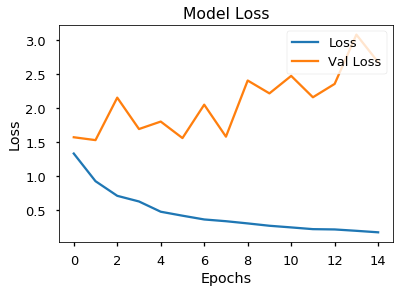

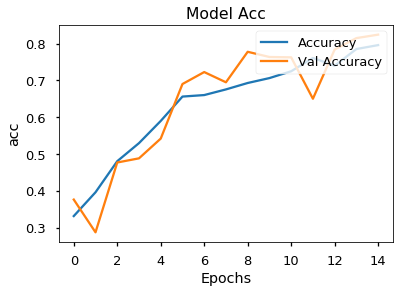

[0 0 3 0 3]
Accuracy sobre validacion: 0.8244705882352941
F1-score None sobre validación: [0.90821256 0.11235955 0.11347518 0.80929332]
F1-score macro sobre validación: 0.4858351521697949
Precision None sobre validación: [0.9366548  0.09345794 0.07619048 0.82283465]
Recall None sobre validación: [0.88144675 0.14084507 0.22222222 0.79619048]


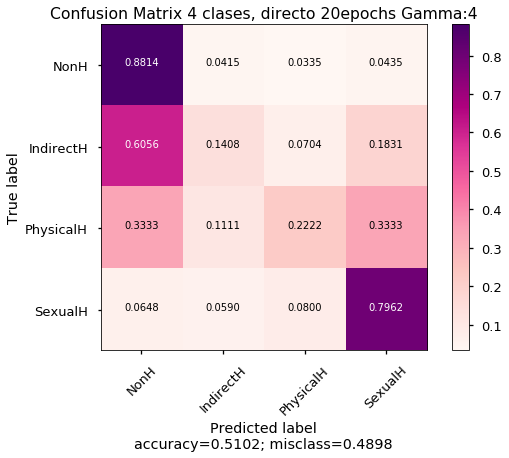

In [59]:
models1 = create_simple_GRU(64,"adam",X_train_rnn[0].shape) #modificar post experimentación
historys1 = models1.fit(X_train_rnn, y_train,epochs=15,batch_size=64,verbose=0, validation_data=(X_val_rnn_ig, y_val))   
plt.plot(historys1.history['loss'],label="Loss")
plt.plot(historys1.history['val_loss'],label="Val Loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(historys1.history['acc'],label="Accuracy" )
plt.plot(historys1.history['val_acc'],label="Val Accuracy" )
plt.title("Model Acc") 
plt.ylabel('acc')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predict = models1.predict(X_val_rnn_ig, batch_size=64).argmax(axis=-1)
print (predict[:5])
acc_val= accuracy_score(y_val_num, predict)
f1_val=f1_score(y_val_num, predict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_num, predict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_num, predict, average=None) 
pre=precision_score(y_val_num, predict, average=None) 
matriz_val=confusion_matrix(y_val_num, predict)
print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH",'IndirectH','PhysicalH','SexualH'],"Confusion Matrix 4 clases, directo 20epochs Gamma:"+str(gamma), cmap='RdPu')

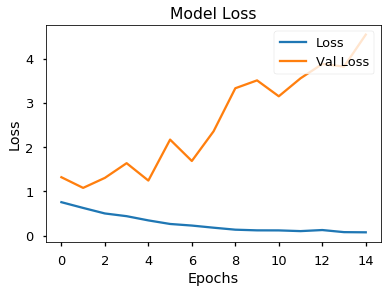

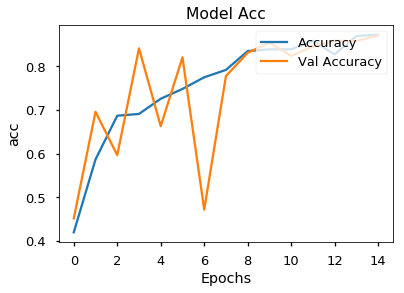

[0 0 3 0 3]
Accuracy sobre validacion: 0.8710588235294118
F1-score None sobre validación: [0.92782813 0.09836066 0.09677419 0.84636615]
F1-score macro sobre validación: 0.49233228122133155
Precision None sobre validación: [0.93001346 0.11764706 0.11538462 0.81850534]
Recall None sobre validación: [0.92565305 0.08450704 0.08333333 0.87619048]


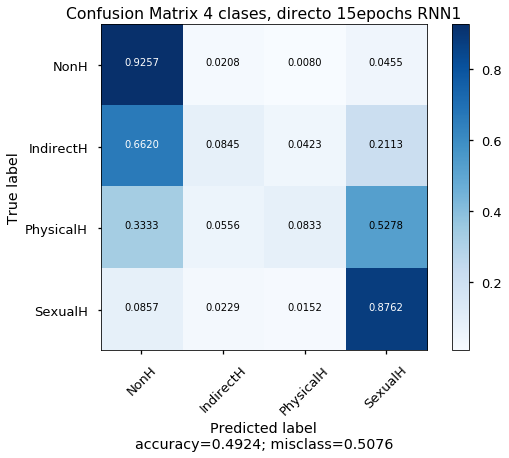

In [60]:
model1 = create_complex_GRU(128,64,"adam",X_train_rnn[0].shape) #modificar post experimentación
history1 = model1.fit(X_train_rnn, y_train,epochs=15,batch_size=64,verbose=0, validation_data=(X_val_rnn_ig, y_val))   
plt.plot(history1.history['loss'],label="Loss")
plt.plot(history1.history['val_loss'],label="Val Loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(history1.history['acc'],label="Accuracy" )
plt.plot(history1.history['val_acc'],label="Val Accuracy" )
plt.title("Model Acc") 
plt.ylabel('acc')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predict = model1.predict(X_val_rnn_ig, batch_size=64).argmax(axis=-1)
print (predict[:5])
acc_val= accuracy_score(y_val_num, predict)
f1_val=f1_score(y_val_num, predict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_num, predict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_num, predict, average=None) 
pre=precision_score(y_val_num, predict, average=None) 
matriz_val=confusion_matrix(y_val_num, predict)
print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH",'IndirectH','PhysicalH','SexualH'],"Confusion Matrix 4 clases, directo 15epochs RNN1")

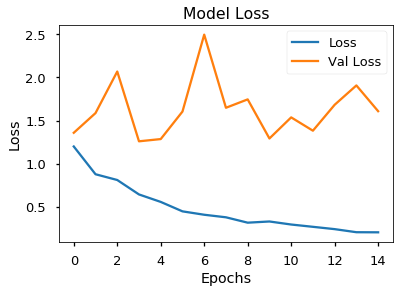

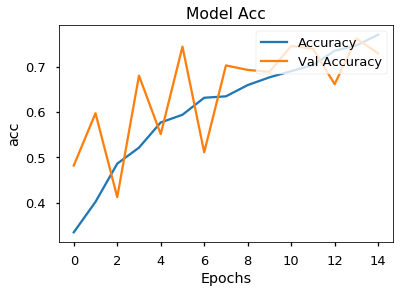

Accuracy sobre validacion: 0.7294117647058823
F1-score None sobre validación: [0.83820225 0.15801354 0.11267606 0.7798995 ]
F1-score macro sobre validación: 0.47219783625863376
Precision None sobre validación: [0.95072218 0.09408602 0.0754717  0.82553191]
Recall None sobre validación: [0.74949766 0.49295775 0.22222222 0.73904762]


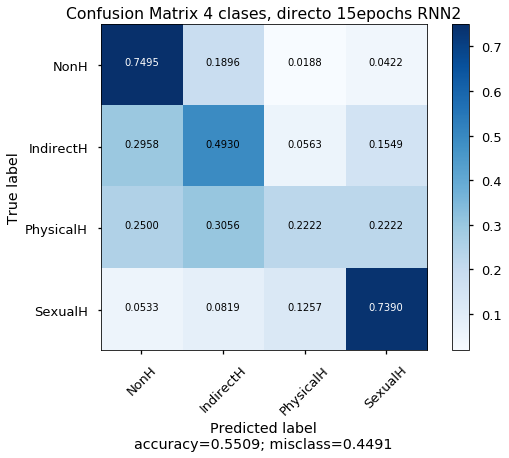

In [14]:
model2 = create_complex_GRU_2(128,64,"adam",X_train_rnn[0].shape) #modificar post experimentación
history2 = model2.fit(X_train_rnn, y_train,epochs=15,batch_size=64,verbose=0, validation_data=(X_val_rnn_ig, y_val))   
plt.plot(history2.history['loss'],label="Loss")
plt.plot(history2.history['val_loss'],label="Val Loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(history2.history['acc'],label="Accuracy" )
plt.plot(history2.history['val_acc'],label="Val Accuracy" )
plt.title("Model Acc") 
plt.ylabel('acc')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predict = model2.predict(X_val_rnn_ig, batch_size=64).argmax(axis=-1)
acc_val= accuracy_score(y_val_num, predict)
f1_val=f1_score(y_val_num, predict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_num, predict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_num, predict, average=None) 
pre=precision_score(y_val_num, predict, average=None) 
matriz_val=confusion_matrix(y_val_num, predict)
print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH",'IndirectH','PhysicalH','SexualH'],"Confusion Matrix 4 clases, directo 15epochs RNN2")

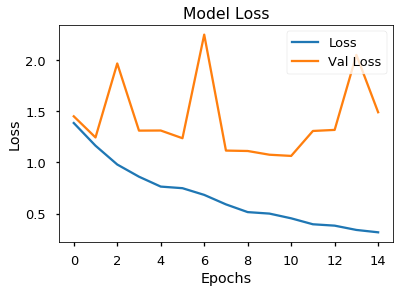

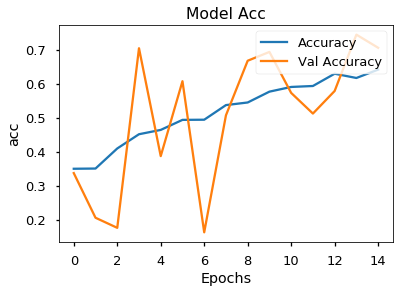

Accuracy sobre validacion: 0.7063529411764706
F1-score None sobre validación: [0.81615385 0.13270142 0.15544041 0.76714976]
F1-score macro sobre validación: 0.4678613602291681
Precision None sobre validación: [0.95844625 0.07977208 0.0955414  0.77843137]
Recall None sobre validación: [0.7106497  0.3943662  0.41666667 0.75619048]


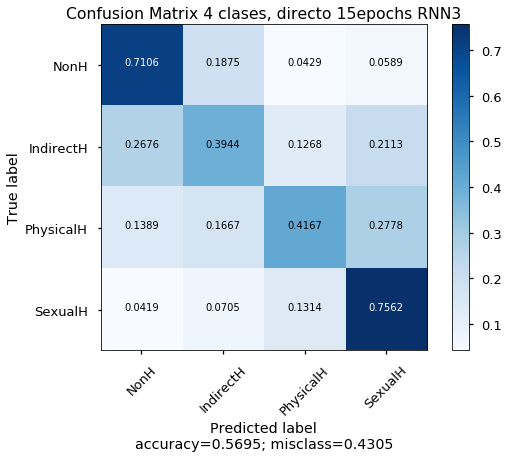

In [15]:
model3 = create_complex_GRU_3(256,128,64,"adam",X_train_rnn[0].shape) #modificar post experimentación
history3 = model3.fit(X_train_rnn, y_train,epochs=15,batch_size=64,verbose=0, validation_data=(X_val_rnn_ig, y_val))   
plt.plot(history3.history['loss'],label="Loss")
plt.plot(history3.history['val_loss'],label="Val Loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(history3.history['acc'],label="Accuracy" )
plt.plot(history3.history['val_acc'],label="Val Accuracy" )
plt.title("Model Acc") 
plt.ylabel('acc')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predict = model3.predict(X_val_rnn_ig, batch_size=64).argmax(axis=-1)
acc_val= accuracy_score(y_val_num, predict)
f1_val=f1_score(y_val_num, predict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_num, predict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_num, predict, average=None) 
pre=precision_score(y_val_num, predict, average=None) 
matriz_val=confusion_matrix(y_val_num, predict)
print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH",'IndirectH','PhysicalH','SexualH'],"Confusion Matrix 4 clases, directo 15epochs RNN3")